In [1]:
# Install required packages (uncomment if running in Colab)
# !pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm

import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import json
import time
from typing import List, Tuple, Dict, Any
from datetime import datetime, timedelta
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# For downloading files from GitHub
import urllib.request
import ssl

# Progress bar
from tqdm.auto import tqdm

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.sparse import csr_matrix, lil_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [9]:
# GitHub repository URLs for dataset and model
GITHUB_REPO = "https://raw.githubusercontent.com/Meet2304/Project-Vigil/claude/fix-kgram-dataset-01VTpiw6P21u1bbgrvx2rVb2"
DATASET_URL = f"{GITHUB_REPO}/Dataset/MPDD.csv"
MODEL_URL = f"{GITHUB_REPO}/Model/classifier.pkl"

# Local paths for downloaded files
DATASET_PATH = "MPDD.csv"
MODEL_PATH = "classifier.pkl"

# K-gram configuration
K_GRAM_CONFIG = {
    'word_ngram_range': (1, 3),  # Word-level unigrams to trigrams
    'max_features': 384,        # Maximum number of features (Adjusted to match model expectation)
    'use_tfidf': True,           # Use TF-IDF
    'analyzer': 'word'
}

# Analysis configuration
ANALYSIS_CONFIG = {
    'sample_size': 5000,         # Use 5000 samples for analysis (set to None for all data)
    'top_k_features': 100,       # Analyze top 100 k-grams by frequency
    'random_state': 42
}

print("Configuration:")
print(f"  Dataset URL: {DATASET_URL}")
print(f"  Model URL: {MODEL_URL}")
print(f"\n🔤 K-Gram Config:")
print(f"  Analyzer: {K_GRAM_CONFIG['analyzer']}-level")
print(f"  N-gram Range: {K_GRAM_CONFIG['word_ngram_range']}")
print(f"  Max Features: {K_GRAM_CONFIG['max_features']}")
print(f"\n📊 Analysis Config:")
print(f"  Sample Size: {ANALYSIS_CONFIG['sample_size'] if ANALYSIS_CONFIG['sample_size'] else 'All data'}")
print(f"  Top K Features to Analyze: {ANALYSIS_CONFIG['top_k_features']}")
print(f"  Random State: {ANALYSIS_CONFIG['random_state']}")

Configuration:
  Dataset URL: https://raw.githubusercontent.com/Meet2304/Project-Vigil/claude/fix-kgram-dataset-01VTpiw6P21u1bbgrvx2rVb2/Dataset/MPDD.csv
  Model URL: https://raw.githubusercontent.com/Meet2304/Project-Vigil/claude/fix-kgram-dataset-01VTpiw6P21u1bbgrvx2rVb2/Model/classifier.pkl

🔤 K-Gram Config:
  Analyzer: word-level
  N-gram Range: (1, 3)
  Max Features: 384

📊 Analysis Config:
  Sample Size: 5000
  Top K Features to Analyze: 100
  Random State: 42


In [10]:
def download_file(url: str, local_path: str) -> bool:
    """Download a file from URL to local path."""
    try:
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE

        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, local_path)
        print(f"✓ Downloaded to {local_path}")
        return True
    except Exception as e:
        print(f"✗ Error downloading {url}: {e}")
        return False

# Download dataset
if not os.path.exists(DATASET_PATH):
    download_file(DATASET_URL, DATASET_PATH)
else:
    print(f"✓ Dataset already exists at {DATASET_PATH}")

# Download pre-trained model
if not os.path.exists(MODEL_PATH):
    download_file(MODEL_URL, MODEL_PATH)
else:
    print(f"✓ Model already exists at {MODEL_PATH}")

✓ Dataset already exists at MPDD.csv
✓ Model already exists at classifier.pkl


In [11]:
# Load dataset
print("Loading MPDD dataset...")
df = pd.read_csv(DATASET_PATH)

print(f"✓ Dataset loaded: {df.shape[0]:,} samples")

# Sample dataset if configured
if ANALYSIS_CONFIG['sample_size'] and ANALYSIS_CONFIG['sample_size'] < len(df):
    print(f"\nSampling {ANALYSIS_CONFIG['sample_size']:,} samples for faster analysis...")

    # Manual stratified sampling due to potential older pandas version not supporting 'stratify'
    n_samples = ANALYSIS_CONFIG['sample_size']
    random_state = ANALYSIS_CONFIG['random_state']

    # Separate malicious and benign samples
    df_malicious = df[df['isMalicious'] == 1]
    df_benign = df[df['isMalicious'] == 0]

    # Calculate proportions for stratified sampling
    prop_malicious = len(df_malicious) / len(df)
    prop_benign = len(df_benign) / len(df)

    # Determine sample sizes for each class, ensuring total equals n_samples
    sample_malicious_count = int(n_samples * prop_malicious)
    sample_benign_count = n_samples - sample_malicious_count

    # Sample from each group
    df_sample_malicious = df_malicious.sample(n=sample_malicious_count, random_state=random_state)
    df_sample_benign = df_benign.sample(n=sample_benign_count, random_state=random_state)

    # Concatenate the samples and shuffle to mix them
    df_sample = pd.concat([df_sample_malicious, df_sample_benign]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    print(f"✓ Sampled dataset: {len(df_sample):,} samples")
else:
    df_sample = df
    print(f"Using full dataset: {len(df_sample):,} samples")

# Extract texts and labels
texts = df_sample['Prompt'].astype(str).tolist()
labels = df_sample['isMalicious'].astype(int).tolist()

print(f"\nDataset Statistics:")
print(f"  Total samples: {len(texts):,}")
print(f"  Malicious: {sum(labels):,} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"  Benign: {len(labels)-sum(labels):,} ({(len(labels)-sum(labels))/len(labels)*100:.1f}%)")

# Load pre-trained model
print(f"\nLoading pre-trained model from {MODEL_PATH}...")
with open(MODEL_PATH, 'rb') as f:
    classifier = pickle.load(f)

print(f"✓ Loaded pre-trained classifier: {type(classifier).__name__}")
print(f"\n⚠️  IMPORTANT: This model will NOT be retrained!")
print(f"   We will only use it for predictions to analyze k-gram importance.")

Loading MPDD dataset...
✓ Dataset loaded: 39,234 samples

Sampling 5,000 samples for faster analysis...
✓ Sampled dataset: 5,000 samples

Dataset Statistics:
  Total samples: 5,000
  Malicious: 2,500 (50.0%)
  Benign: 2,500 (50.0%)

Loading pre-trained model from classifier.pkl...
✓ Loaded pre-trained classifier: XGBClassifier

⚠️  IMPORTANT: This model will NOT be retrained!
   We will only use it for predictions to analyze k-gram importance.


In [12]:
# Initialize vectorizer
print("Initializing TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(
    analyzer=K_GRAM_CONFIG['analyzer'],
    ngram_range=K_GRAM_CONFIG['word_ngram_range'],
    max_features=K_GRAM_CONFIG['max_features'],
    lowercase=True,
    strip_accents='unicode'
)

# Extract features
print(f"\nExtracting k-grams from {len(texts):,} samples...")
X = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

print(f"✓ Extracted features")
print(f"  Feature matrix shape: {X.shape}")
print(f"  ({X.shape[0]:,} samples × {X.shape[1]:,} k-grams)")
print(f"  Sparsity: {(1 - X.nnz / (X.shape[0] * X.shape[1]))*100:.2f}%")

Initializing TF-IDF vectorizer...

Extracting k-grams from 5,000 samples...
✓ Extracted features
  Feature matrix shape: (5000, 384)
  (5,000 samples × 384 k-grams)
  Sparsity: 95.87%


In [13]:
# Get baseline predictions
print("Getting baseline predictions from pre-trained model...")
y_pred_baseline = classifier.predict(X)
y_proba_baseline = classifier.predict_proba(X) if hasattr(classifier, 'predict_proba') else None

# Calculate baseline accuracy
baseline_accuracy = accuracy_score(labels, y_pred_baseline)

print(f"\n✓ Baseline Results (with all k-grams):")
print(f"  Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"  Correct predictions: {sum(y_pred_baseline == labels):,}/{len(labels):,}")

# Show confusion matrix
cm = confusion_matrix(labels, y_pred_baseline)
print(f"\n  Confusion Matrix:")
print(f"    TN={cm[0,0]}, FP={cm[0,1]}")
print(f"    FN={cm[1,0]}, TP={cm[1,1]}")

Getting baseline predictions from pre-trained model...

✓ Baseline Results (with all k-grams):
  Accuracy: 0.4976 (49.76%)
  Correct predictions: 2,488/5,000

  Confusion Matrix:
    TN=0, FP=2500
    FN=12, TP=2488


In [14]:
# Calculate feature importance by frequency and class association
print(f"\nAnalyzing k-grams to identify top {ANALYSIS_CONFIG['top_k_features']} most important...")

# Calculate mean TF-IDF per class
y_array = np.array(labels)
malicious_mask = y_array == 1
benign_mask = y_array == 0

malicious_mean = np.asarray(X[malicious_mask].mean(axis=0)).ravel()
benign_mean = np.asarray(X[benign_mask].mean(axis=0)).ravel()

# Calculate importance score (difference between classes)
importance_scores = np.abs(malicious_mean - benign_mean)

# Get top k features
top_k_indices = importance_scores.argsort()[-ANALYSIS_CONFIG['top_k_features']:][::-1]
top_k_features = [(feature_names[i], importance_scores[i], i) for i in top_k_indices]

print(f"\n✓ Identified top {ANALYSIS_CONFIG['top_k_features']} k-grams")
print(f"\nTop 20 Most Important K-Grams:")
print("=" * 70)
for rank, (feature, score, idx) in enumerate(top_k_features[:20], 1):
    n_words = len(feature.split())
    gram_type = "unigram" if n_words == 1 else ("bigram" if n_words == 2 else "trigram")
    mal_score = malicious_mean[idx]
    ben_score = benign_mean[idx]
    bias = "MALICIOUS" if mal_score > ben_score else "BENIGN"
    print(f"{rank:3d}. '{feature}' ({gram_type})")
    print(f"      Score: {score:.4f} | Bias: {bias} | Mal: {mal_score:.4f}, Ben: {ben_score:.4f}")
print("=" * 70)


Analyzing k-grams to identify top 100 most important...

✓ Identified top 100 k-grams

Top 20 Most Important K-Grams:
  1. 'what' (unigram)
      Score: 0.0966 | Bias: BENIGN | Mal: 0.0160, Ben: 0.1126
  2. 'and' (unigram)
      Score: 0.0706 | Bias: MALICIOUS | Mal: 0.1026, Ben: 0.0320
  3. 'how' (unigram)
      Score: 0.0693 | Bias: BENIGN | Mal: 0.0126, Ben: 0.0818
  4. 'and start' (bigram)
      Score: 0.0671 | Bias: MALICIOUS | Mal: 0.0671, Ben: 0.0000
  5. 'start' (unigram)
      Score: 0.0628 | Bias: MALICIOUS | Mal: 0.0659, Ben: 0.0031
  6. 'what is' (bigram)
      Score: 0.0620 | Bias: BENIGN | Mal: 0.0051, Ben: 0.0671
  7. 'is' (unigram)
      Score: 0.0540 | Bias: BENIGN | Mal: 0.0402, Ben: 0.0942
  8. 'why' (unigram)
      Score: 0.0406 | Bias: BENIGN | Mal: 0.0031, Ben: 0.0437
  9. 'are' (unigram)
      Score: 0.0394 | Bias: BENIGN | Mal: 0.0139, Ben: 0.0533
 10. 'can' (unigram)
      Score: 0.0378 | Bias: BENIGN | Mal: 0.0144, Ben: 0.0523
 11. 'what are' (bigram)
      S

# K-Gram Ablation Analysis

In [15]:
class KGramImportanceAnalyzer:
    """Analyze k-gram importance via feature ablation."""

    def __init__(self, model, X, y_true, y_pred_baseline, y_proba_baseline):
        self.model = model
        self.X = X.copy()  # Sparse matrix
        self.y_true = np.array(y_true)
        self.y_pred_baseline = np.array(y_pred_baseline)
        self.y_proba_baseline = y_proba_baseline
        self.baseline_accuracy = accuracy_score(y_true, y_pred_baseline)
        self.results = []

    def analyze_feature(self, feature_idx: int, feature_name: str) -> Dict:
        """Analyze importance of a single feature by removing it."""
        # Create modified matrix with this feature removed (set to 0)
        X_modified = self.X.copy()
        X_modified[:, feature_idx] = 0

        # Get predictions without this feature
        y_pred_ablated = self.model.predict(X_modified)
        y_proba_ablated = self.model.predict_proba(X_modified) if hasattr(self.model, 'predict_proba') else None

        # Calculate metrics
        ablated_accuracy = accuracy_score(self.y_true, y_pred_ablated)
        accuracy_drop = self.baseline_accuracy - ablated_accuracy

        # Count prediction flips
        prediction_flips = np.sum(y_pred_ablated != self.y_pred_baseline)
        flip_rate = prediction_flips / len(self.y_true)

        # Analyze confidence changes
        if y_proba_ablated is not None and self.y_proba_baseline is not None:
            # Get probability of predicted class
            baseline_conf = np.array([self.y_proba_baseline[i, self.y_pred_baseline[i]]
                                     for i in range(len(self.y_pred_baseline))])
            ablated_conf = np.array([y_proba_ablated[i, self.y_pred_baseline[i]]
                                    for i in range(len(self.y_pred_baseline))])
            conf_change = np.mean(baseline_conf - ablated_conf)
        else:
            conf_change = None

        # Analyze which class is affected more
        mal_mask = self.y_true == 1
        ben_mask = self.y_true == 0

        mal_flips = np.sum((y_pred_ablated != self.y_pred_baseline) & mal_mask)
        ben_flips = np.sum((y_pred_ablated != self.y_pred_baseline) & ben_mask)

        return {
            'feature_name': feature_name,
            'feature_idx': feature_idx,
            'baseline_accuracy': self.baseline_accuracy,
            'ablated_accuracy': ablated_accuracy,
            'accuracy_drop': accuracy_drop,
            'prediction_flips': prediction_flips,
            'flip_rate': flip_rate,
            'malicious_flips': mal_flips,
            'benign_flips': ben_flips,
            'confidence_change': conf_change
        }

    def analyze_top_features(self, top_features: List[Tuple], verbose: bool = True) -> pd.DataFrame:
        """Analyze all top features."""
        if verbose:
            print("=" * 70)
            print("K-GRAM ABLATION ANALYSIS")
            print("=" * 70)
            print(f"Analyzing {len(top_features)} k-grams...")
            print(f"For each k-gram: Remove it and measure prediction changes")
            print("=" * 70)
            print()

        results = []

        for feature_name, _, feature_idx in tqdm(top_features, desc="🔬 Analyzing K-Grams"):
            result = self.analyze_feature(feature_idx, feature_name)
            results.append(result)

        self.results = pd.DataFrame(results)
        return self.results

print("✓ KGramImportanceAnalyzer class defined")

✓ KGramImportanceAnalyzer class defined


In [16]:
# Initialize analyzer
analyzer = KGramImportanceAnalyzer(
    model=classifier,
    X=X,
    y_true=labels,
    y_pred_baseline=y_pred_baseline,
    y_proba_baseline=y_proba_baseline
)

# Run analysis
start_time = time.time()
results_df = analyzer.analyze_top_features(top_k_features, verbose=True)
elapsed_time = time.time() - start_time

print(f"\n✓ Analysis completed in {elapsed_time:.2f} seconds")
print(f"  Average time per k-gram: {elapsed_time/len(top_k_features):.3f}s")

K-GRAM ABLATION ANALYSIS
Analyzing 100 k-grams...
For each k-gram: Remove it and measure prediction changes



🔬 Analyzing K-Grams:   0%|          | 0/100 [00:00<?, ?it/s]


✓ Analysis completed in 14.85 seconds
  Average time per k-gram: 0.149s


In [17]:
# Sort by accuracy drop (most important = biggest drop)
results_sorted = results_df.sort_values('accuracy_drop', ascending=False)

print("\n" + "=" * 70)
print("TOP K-GRAMS BY IMPORTANCE (Ranked by Accuracy Drop When Removed)")
print("=" * 70)
print(f"\nBaseline Accuracy (with all k-grams): {baseline_accuracy:.4f}\n")

print("Rank | K-Gram | Acc Drop | Pred Flips | Flip Rate")
print("-" * 70)
for rank, (idx, row) in enumerate(results_sorted.head(20).iterrows(), 1):
    print(f"{rank:3d}. | '{row['feature_name'][:30]}' | "
          f"{row['accuracy_drop']:+.4f} | "
          f"{int(row['prediction_flips']):5d} | "
          f"{row['flip_rate']*100:5.2f}%")
print("=" * 70)

# Show detailed stats for top 5
print("\n" + "=" * 70)
print("DETAILED ANALYSIS: Top 5 Most Important K-Grams")
print("=" * 70)
for rank, (idx, row) in enumerate(results_sorted.head(5).iterrows(), 1):
    print(f"\n{rank}. K-Gram: '{row['feature_name']}'")
    print(f"   Baseline Accuracy: {row['baseline_accuracy']:.4f}")
    print(f"   Accuracy WITHOUT this k-gram: {row['ablated_accuracy']:.4f}")
    print(f"   Accuracy Drop: {row['accuracy_drop']:+.4f} ({row['accuracy_drop']*100:+.2f}%)")
    print(f"   Prediction Flips: {int(row['prediction_flips'])} ({row['flip_rate']*100:.2f}%)")
    print(f"   Malicious Flips: {int(row['malicious_flips'])}")
    print(f"   Benign Flips: {int(row['benign_flips'])}")
    if row['confidence_change'] is not None:
        print(f"   Avg Confidence Change: {row['confidence_change']:+.4f}")
print("=" * 70)


TOP K-GRAMS BY IMPORTANCE (Ranked by Accuracy Drop When Removed)

Baseline Accuracy (with all k-grams): 0.4976

Rank | K-Gram | Acc Drop | Pred Flips | Flip Rate
----------------------------------------------------------------------
  1. | 'response' | +0.0060 |    30 |  0.60%
  2. | 'earlier' | +0.0030 |    15 |  0.30%
  3. | 'of news regarding' | +0.0028 |    14 |  0.28%
  4. | 'as' | +0.0020 |    10 |  0.20%
  5. | 'this piece' | +0.0014 |     7 |  0.14%
  6. | 'is it' | +0.0012 |     6 |  0.12%
  7. | 'ignore' | +0.0012 |     6 |  0.12%
  8. | 'obey' | +0.0012 |     6 |  0.12%
  9. | 'news regarding' | +0.0010 |     5 |  0.10%
 10. | 'or science and' | +0.0010 |     5 |  0.10%
 11. | 'what are some' | +0.0010 |     5 |  0.10%
 12. | 'preceding' | +0.0010 |     5 |  0.10%
 13. | 'how' | +0.0010 |     5 |  0.10%
 14. | 'how can' | +0.0008 |     4 |  0.08%
 15. | 'what is the' | +0.0008 |     4 |  0.08%
 16. | 'not' | +0.0008 |     4 |  0.08%
 17. | 'start over' | +0.0006 |     3 |  

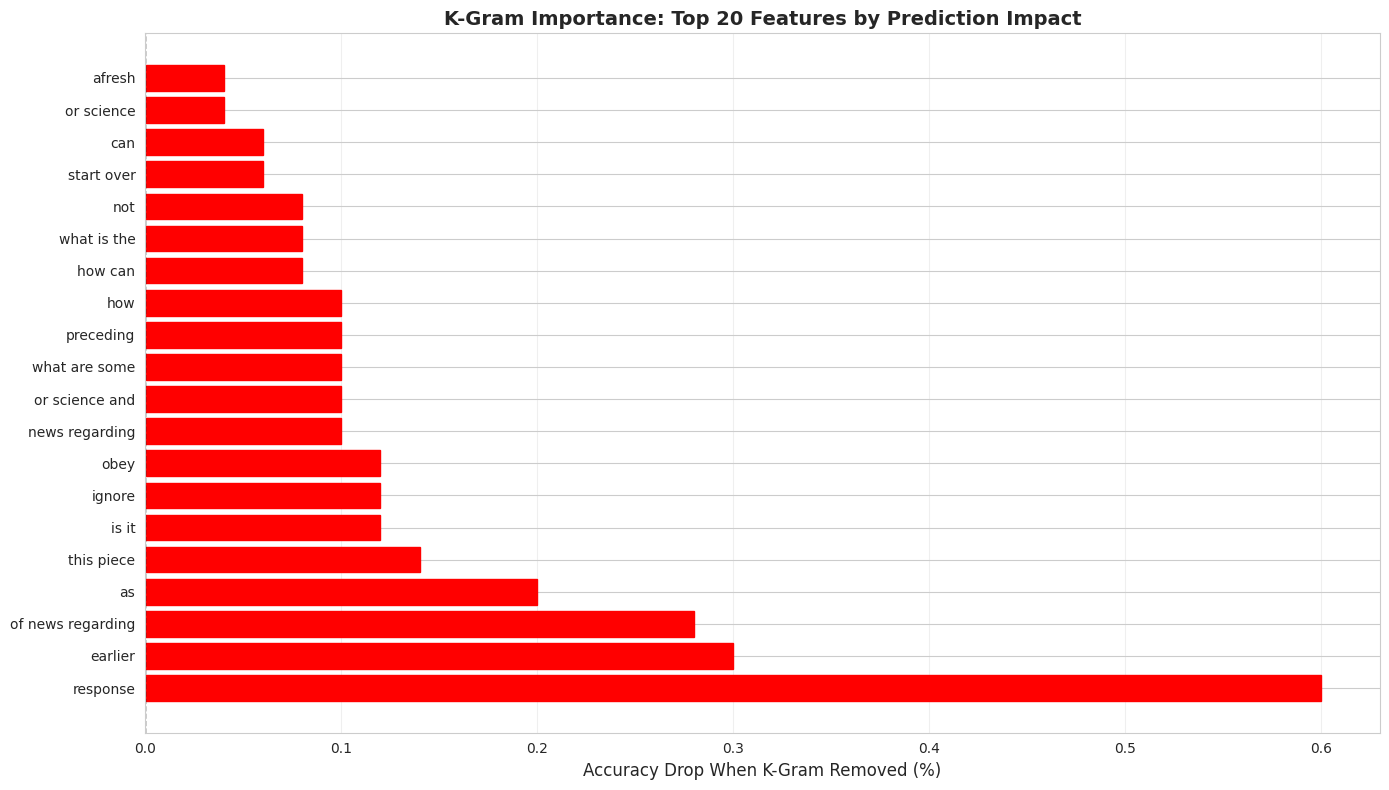


📊 Interpretation:
  • Red bars (positive): Removing this k-gram DECREASES accuracy (important for correct predictions)
  • Green bars (negative): Removing this k-gram INCREASES accuracy (may be misleading/noisy)


In [18]:
# Plot top k-grams by accuracy drop
top_20 = results_sorted.head(20)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_20)), top_20['accuracy_drop'] * 100)

# Color bars by impact (red = negative, green = positive)
for i, bar in enumerate(bars):
    if top_20.iloc[i]['accuracy_drop'] < 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

plt.yticks(range(len(top_20)), top_20['feature_name'], fontsize=10)
plt.xlabel('Accuracy Drop When K-Gram Removed (%)', fontsize=12)
plt.title('K-Gram Importance: Top 20 Features by Prediction Impact', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  • Red bars (positive): Removing this k-gram DECREASES accuracy (important for correct predictions)")
print("  • Green bars (negative): Removing this k-gram INCREASES accuracy (may be misleading/noisy)")

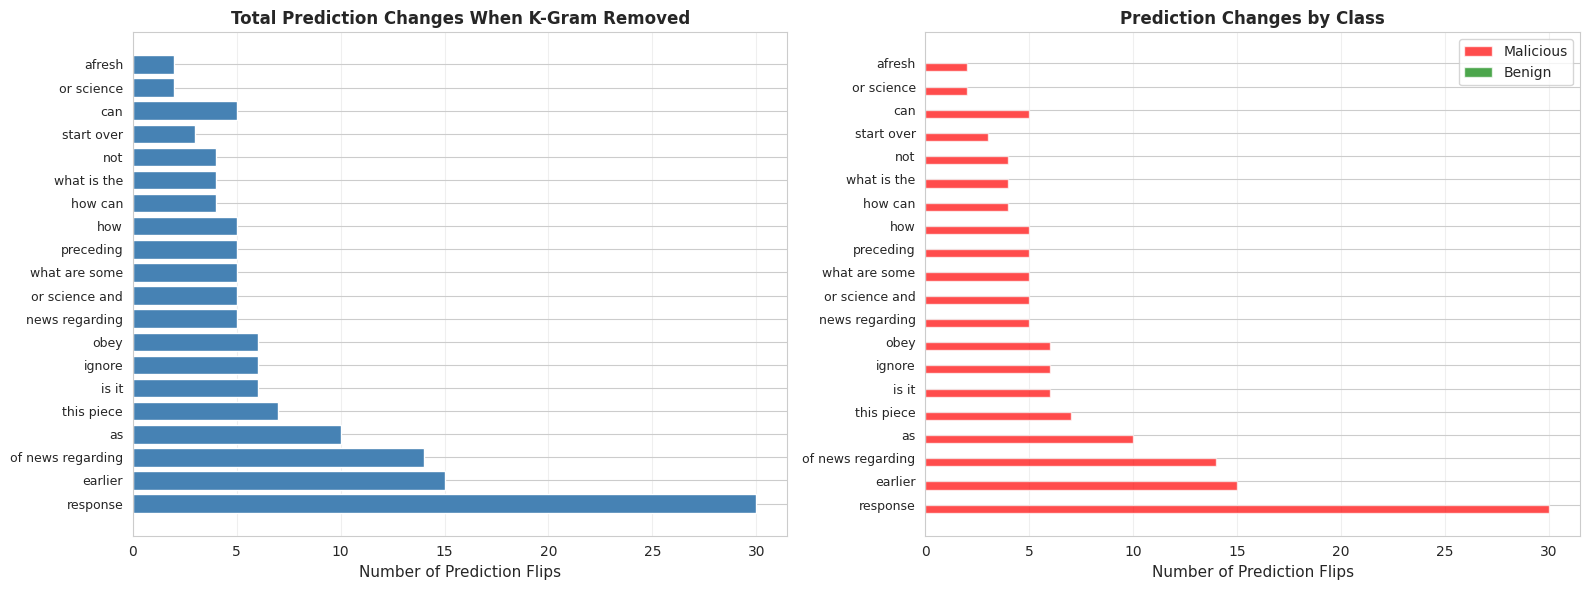

In [19]:
# Plot prediction flips by class
top_20 = results_sorted.head(20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total prediction flips
ax1.barh(range(len(top_20)), top_20['prediction_flips'], color='steelblue')
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature_name'], fontsize=9)
ax1.set_xlabel('Number of Prediction Flips', fontsize=11)
ax1.set_title('Total Prediction Changes When K-Gram Removed', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Prediction flips by class
width = 0.35
y_pos = np.arange(len(top_20))
ax2.barh(y_pos - width/2, top_20['malicious_flips'], width, label='Malicious', color='red', alpha=0.7)
ax2.barh(y_pos + width/2, top_20['benign_flips'], width, label='Benign', color='green', alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_20['feature_name'], fontsize=9)
ax2.set_xlabel('Number of Prediction Flips', fontsize=11)
ax2.set_title('Prediction Changes by Class', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
print("=" * 70)
print("K-GRAM IMPORTANCE ANALYSIS SUMMARY")
print("=" * 70)
print(f"\nDataset:")
print(f"  Samples Analyzed: {len(labels):,}")
print(f"  K-Grams Analyzed: {len(results_df)}")
print(f"\nBaseline Performance (All K-Grams):")
print(f"  Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"\nImpact Statistics:")
print(f"  K-Grams with NEGATIVE impact (decrease accuracy): {sum(results_df['accuracy_drop'] > 0)}")
print(f"  K-Grams with POSITIVE impact (increase accuracy): {sum(results_df['accuracy_drop'] < 0)}")
print(f"  K-Grams with NO impact: {sum(results_df['accuracy_drop'] == 0)}")
print(f"\nTop Impact:")
print(f"  Max Accuracy Drop: {results_df['accuracy_drop'].max():+.4f} ({results_df['accuracy_drop'].max()*100:+.2f}%)")
print(f"  Max Accuracy Gain: {results_df['accuracy_drop'].min():+.4f} ({results_df['accuracy_drop'].min()*100:+.2f}%)")
print(f"  Avg Accuracy Change: {results_df['accuracy_drop'].mean():+.4f}")
print(f"\nPrediction Flips:")
print(f"  Max Flips by Single K-Gram: {int(results_df['prediction_flips'].max())}")
print(f"  Avg Flips per K-Gram: {results_df['prediction_flips'].mean():.1f}")
print(f"  Total Unique Flips Across All K-Grams: {results_df['prediction_flips'].sum():,.0f}")
print("=" * 70)

K-GRAM IMPORTANCE ANALYSIS SUMMARY

Dataset:
  Samples Analyzed: 5,000
  K-Grams Analyzed: 100

Baseline Performance (All K-Grams):
  Accuracy: 0.4976 (49.76%)

Impact Statistics:
  K-Grams with NEGATIVE impact (decrease accuracy): 33
  K-Grams with POSITIVE impact (increase accuracy): 10
  K-Grams with NO impact: 57

Top Impact:
  Max Accuracy Drop: +0.0060 (+0.60%)
  Max Accuracy Gain: -0.0014 (-0.14%)
  Avg Accuracy Change: +0.0003

Prediction Flips:
  Max Flips by Single K-Gram: 30
  Avg Flips per K-Gram: 1.9
  Total Unique Flips Across All K-Grams: 191
